<a href="https://colab.research.google.com/github/giordamaug/LION15_Experiments/blob/main/LION15SI_DGCNN_Stellargraph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DGCNN experiments as embedding method (LION15 SI)
In this notebook we implement a Deep Graph Convolutional Neural Network (DGCNN) [1] algorithm according to the colab: [Supervised graph classification with Deep Graph CNN
](https://colab.research.google.com/github/stellargraph/stellargraph/blob/master/demos/graph-classification/dgcnn-graph-classification.ipynb).

The DGCNN implememntation uses the [StellarGraph](https://www.stellargraph.io/) Library. The DGCNN implementation has been modified in such a way to function as an inductive graph embedding method. To this aim the DGCNN model is fed with input graphs and the output of the last hidden layer is extracted and used as the embedding of the input graph. The graph embedding are then used as input to a SVM with linear kernel for 10-fold cross-validation.

In addition, our modified version of the DGCNN accepts has input graphml files by means of the [NetworkX](https://networkx.org/) Library.

**References**

[1] An End-to-End Deep Learning Architecture for Graph Classification, M. Zhang, Z. Cui, M. Neumann, Y. Chen, AAAI-18. ([link](https://www.aaai.org/ocs/index.php/AAAI/AAAI18/paper/viewPaper/17146))

[2] Semi-supervised Classification with Graph Convolutional Networks, T. N. Kipf and M. Welling, ICLR 2017. ([link](https://arxiv.org/abs/1609.02907))

## Install Stellargraph
The folowing code installs the StellarGraph library and all the other python packages required for execution (TensorFlow, NetworkX, Pandas, )

In [ ]:
# install StellarGraph if running on Google Colab
import warnings
warnings.filterwarnings("ignore")

import sys
if 'google.colab' in sys.modules:
  %pip install -q stellargraph[demos]==1.2.1
# verify that we're using the correct version of StellarGraph for this notebook
import stellargraph as sg
try:
    sg.utils.validate_notebook_version("1.2.1")
except AttributeError:
    raise ValueError(
        f"This notebook requires StellarGraph version 1.2.1, but a different version {sg.__version__} is installed.  Please see <https://github.com/stellargraph/stellargraph/issues/1172>."
    ) from None
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print('Not Found GPU at: {}'.format(device_name))
else:
  print('Found GPU at: {}'.format(device_name))
from IPython.display import display, HTML
from time import time
import stellargraph as sg
import pandas as pd
import numpy as np
import networkx as nx
import tensorflow as tf
from tensorflow import keras
from stellargraph.mapper import PaddedGraphGenerator
from stellargraph.layer import DeepGraphCNN, GCNSupervisedGraphClassification
from stellargraph import StellarGraph
from stellargraph import datasets
from stellargraph.datasets.dataset_loader import DatasetLoader
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Conv1D, MaxPool1D, Dropout, Flatten
from tensorflow.keras.losses import binary_crossentropy, categorical_crossentropy
import tensorflow as tf
from tensorflow.keras import backend as K
from sklearn import model_selection
from sklearn import preprocessing
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix,matthews_corrcoef,accuracy_score,precision_score,f1_score, recall_score
import tqdm as tq
import networkx as nx
import operator
import random

     |████████████████████████████████| 435 kB 5.3 MB/s 
     |████████████████████████████████| 379 kB 30.4 MB/s 
     |████████████████████████████████| 45 kB 3.4 MB/s 
Found GPU at: /device:GPU:0


## The edge attack routine
Currently two strategies have been implemneted for edge removal attacks:
1. random selection
2. based on betweness centrality of edges

The routine accepts as input the removal criteria (`random`, `betweeness`), the amount (in `percentage`) of edges to remove, and a random seed (for reprucibility of experiments)

In [ ]:
def nx_edgeattack(G: nx.Graph, criteria = "random", percentage=30, verbose=False, random_state=42):
  at = percentage/100.0
  #remove_zero_weights(G)
  if criteria == "betweeness":
    score = nx.edge_betweenness(G).items()
  elif criteria == "degree":
    raise Exception("Wrong criteria")
  elif criteria == "random":
    score = list(G.edges())
    random.Random(random_state).shuffle(score)
    score = list(dict(zip(score,range(len(score)))).items())
  else:
    raise Exception("Wrong criteria")
  edges_to_remove = sorted(score, key=operator.itemgetter(1, 0), reverse=True)[0:int(len(score)*at)]
  #assert len(edges_to_remove) > 0, "Nothing to remove!"
  for e,w in edges_to_remove:
    G.remove_edge(e[0], e[1])
  if verbose:
    print("removed", edges_to_remove)
  return 0,len(edges_to_remove)

## The dataset loading function
The dataset of graphs in (TUD formats) is converted into the StellarGraph graph data format. The loading procedure (`load_dataset`) generates two copies of the dataset: the first is the original graph set, while the second is the dataset modified by the attacking routine (edge removal). The third argument is a pandas dataframe containing for each graph name the associated label (used for classification/training).

In [ ]:
def load_dataset(dataset, root_dir='.', edge_labels_as_weights=False):

    def _load_from_txt_file(filename, names=None, dtype=None, index_increment=None):
        df = pd.read_csv(
            f"{root_dir}/{dataset}/{dataset}_{filename}.txt",
            header=None,
            index_col=False,
            dtype=dtype,
            names=names,
        )
        # We optional increment the index by 1 because indexing, e.g. node IDs, for this dataset starts
        # at 1 whereas the Pandas DataFrame implicit index starts at 0 potentially causing confusion selecting
        # rows later on.
        if index_increment:
            df.index = df.index + index_increment
        return df

    # edge information:
    df_graph = _load_from_txt_file(filename="A", names=["source", "target"])

    if edge_labels_as_weights and os.path.exists(f"{root_dir}/{dataset}/{dataset}_node_attributes.txt"):
        # there's some edge labels, that can be used as edge weights
        df_edge_labels = _load_from_txt_file(
            filename="edge_labels", names=["weight"], dtype=int
        )
        df_graph = pd.concat([df_graph, df_edge_labels], axis=1)

    # node information:
    df_graph_ids = _load_from_txt_file(
        filename="graph_indicator", names=["graph_id"], index_increment=1
    )

    df_node_labels = _load_from_txt_file(
        filename="node_labels", dtype="category", index_increment=1
    )
    # One-hot encode the node labels because these are used as node features in graph classification
    # tasks.
    df_node_features = pd.get_dummies(df_node_labels)

    if os.path.exists(f"{root_dir}/{dataset}/{dataset}_node_attributes.txt"):
        # there's some actual node attributes
        df_node_attributes = _load_from_txt_file(
            filename="node_attributes", dtype=np.float32, index_increment=1
        )

        df_node_features = pd.concat([df_node_features, df_node_attributes], axis=1)

    # graph information:
    df_graph_labels = _load_from_txt_file(
        filename="graph_labels", dtype="category", names=["label"], index_increment=1
    )

    # split the data into each of the graphs, based on the nodes in each one
    def graph_for_nodes(nodes):
        # each graph is disconnected, so the source is enough to identify the graph for an edge
        edges = df_graph[df_graph["source"].isin(nodes.index)]
        return StellarGraph(nodes, edges)

    groups = df_node_features.groupby(df_graph_ids["graph_id"])
    graphs = [graph_for_nodes(nodes) for _, nodes in groups]

    return graphs, df_graph_labels["label"]

## Define GCNN (and GNN) model
This code snippet is the definition of the DGCNN network. In addition GNN model is also defined as additional comparison method (not used in the experiments). Note how, if it is a binary classification problem (or a multiclass problem), the last layer of the network has only one output node (or as many nodes as the number of classes), whereas its activation function is a sigmoid (or a softmax) function.
![picture](https://stellargraph.readthedocs.io/en/stable/_images/dgcnn_architecture.png)

In [ ]:
# The GCNN model
def create_dgcnn_model(generator, size, nouts, learnrate=0.0001):
      k = 35  # the number of rows for the output tensor
      layer_sizes = [size, size, size, nouts]
      dgcnn_model = DeepGraphCNN(layer_sizes=layer_sizes,activations=["tanh", "tanh", "tanh", "tanh"],k=k,bias=False,generator=generator)
      x_inp, x_out = dgcnn_model.in_out_tensors()
      x_out = Conv1D(filters=16, kernel_size=sum(layer_sizes), strides=sum(layer_sizes))(x_out)
      x_out = MaxPool1D(pool_size=2)(x_out)
      x_out = Conv1D(filters=32, kernel_size=5, strides=1)(x_out)
      x_out = Flatten()(x_out)
      x_out = Dense(units=size, activation="relu")(x_out)
      x_out = embedlayer = Dropout(rate=0.5)(x_out)
      if nouts > 2:
        predictions = Dense(units=nouts, activation="softmax")(x_out)
        model = Model(inputs=x_inp, outputs=predictions)
        model.compile(optimizer=Adam(lr=learnrate), loss=categorical_crossentropy, metrics=["acc"],)
      else:
        predictions = Dense(units=1, activation="sigmoid")(x_out)
        model = Model(inputs=x_inp, outputs=predictions)
        model.compile(optimizer=Adam(lr=learnrate), loss=binary_crossentropy, metrics=["acc"],)
      embedding = Model(inputs=x_inp, outputs=embedlayer)
      return model, embedding

## Load the dataset from TUD format

This code snippet loads the dataset of graphs (in TUD format) as well as it performs graph attacks (see the above defined `load_dataset` procedure. At the end a summary of graph modifications is printed out.



In [ ]:
import tqdm as tq
dataname = 'MUTAG' #@param ['MUTAG', 'KIDNEY', 'Kidney_9.2', 'PROTEINS', 'JE']
criteria = 'random' #@param ['random', 'betweeness']
percentage = 50 #@param [0, 5, 10, 20, 30, 40, 50] {type:"raw"}
ontest = False #@param {type:"boolean"}
import shutil
shutil.unpack_archive(f'../datasets/{dataname}.zip', '../datasets/')
graphs, graph_labels = load_dataset(dataname, root_dir='../datasets')
graphsadv = []  # no attack if dataset is loaded from TU format
for G in tq.tqdm(graphs, desc="Copy/Attack"):
  Gadv = G.to_networkx()
  ec = Gadv.number_of_edges()
  if percentage > 0: 
    n,e = nx_edgeattack(Gadv, criteria=criteria, percentage=percentage, random_state=42)
  graphsadv += [sg.StellarGraph.from_networkx(Gadv,node_type_default="default", edge_type_default="default", node_type_attr="type", edge_type_attr="type", edge_weight_attr="weight", node_features='feature')]
if graph_labels.nunique() > 2:
  y = pd.get_dummies(graph_labels)
else:
  y = pd.get_dummies(graph_labels, drop_first=True)
print(graphs[0].node_features())
print(graphs[0].info())
print(y)
nclasses = len(y.columns)
print("No Classes %d\n"%nclasses)
summary = pd.DataFrame(
    [(g.number_of_nodes(), g.number_of_edges(),ga.number_of_nodes(), ga.number_of_edges()) for g,ga in zip(graphs,graphsadv)],
    columns=["(Graph) nodes", "(Graph) edges", "(Attacked Graph) nodes", "(Attacked Graph) edges"],
)

Loading MUTAG graphs with networkx...


  0%|          | 0/188 [00:00<?, ?it/s]

Removed 0 nodes (over 16) and 3 edges (over 18) in last graph!
label
1        125
0         63
dtype: int64
[[1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]]
StellarGraph: Undirected multigraph
 Nodes: 17, Edges: 19

 Node types:
  default: [17]
    Features: float32 vector, length 7
    Edge types: default-default->default

 Edge types:
    default-default->default: [19]
        Weights: all 0
        Features: none
     1
1    1
2    0
3    0
4    1
5    0
..  ..
184  1
185  0
186  0
187  1
188  0

[188 rows x 1 columns]
No Classes 1



,(Graph) nodes,(Graph) edges,(Attacked Graph) nodes,(Attacked Graph) edges
count,188.0,188.0,188.0,188.0
mean,17.9,19.8,17.9,16.3
std,4.6,5.7,4.6,4.5
min,10.0,10.0,10.0,8.0
25%,14.0,14.0,14.0,12.0
50%,17.5,19.0,17.5,16.0
75%,22.0,25.0,22.0,20.0
max,28.0,33.0,28.0,27.0


In [ ]:
G = np.array(graphs)
from sklearn.model_selection import RepeatedKFold,StratifiedKFold
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
for train_index, test_index in tq.tqdm(list(skf.split(graphs,y)), desc="fold: "):
  print(graph_labels[test_index+1], pd.DataFrame(data=graph_labels[test_index+1]))

# Set/Load model parameters (and save them)

We can load a default parameter setting for the model from a file.
Otherwise we can experiment with different paramter setting.
Once you choose your paramter configuration, you can store it in a file.

### Load defaults

In [ ]:
import os
import json
method='DGCNN'
confpath = '/content/drive/MyDrive/CDS-GROUP-ROOT/TUDatasets/LION15_results' #@param {type:"string"}
path = os.path.join(confpath, f'{method}_{dataset}_params.json')
if os.path.isfile(path):
  params = json.load( open( path, 'r' ) )
  print(params)
else:
  print("No default found!")

{'layerdim': 32, 'epochs': 100, 'learningrate': 0.0001, 'verbose': False, 'seed': 42}


### ... or tune the parameters

In [ ]:
layerdim = 32 #@param ["16", "32", "64"] {type:"raw"}
epochs = 100 #@param {type:"slider", min:0, max:1000, step:10}
learningrate = 0.0001 #@param {type:"number"}
verbose = False #@param {type:"boolean"}
seed = 42 #@param {type:"number"}
save_params = True #@param {type:"boolean"}
outpath = '/content/drive/MyDrive/CDS-GROUP-ROOT/TUDatasets/LION15_results' #@param {type:"string"}

params = {'layerdim': layerdim, 
          'epochs':epochs,
          'learningrate':learningrate,
          'verbose':verbose, 
          'seed':seed,
          }
import json
if save_params:
  path = os.path.join(outpath, f'{method}_{dataset}_params.json')
  json.dump( params, open( path, 'w' ) )

## Validation
Thsi is the main part of the experiment. Once data have been loaded and modified (by the attacking routine), we carry on a stratified 10-fold cross-validation of the pipeline consisting in the DGCNN embedding model plus a SVM linear kernel classifier.

In each fold a DGCNN model is trained on 90% of the dataset; the so-trained model is used to embed both the training and the testing samples (inductively). Then the embedding arrays are used as training/testing inputs of the SVM classifier. We collect predictions results for all folds, and the mean and standard deviation of several metric are printed out (Accuracy, Precision, F-measure, Recall and Matthews Correlation Coefficients). 

In [ ]:
from stellargraph.mapper import PaddedGraphGenerator
from stellargraph.layer import DeepGraphCNN, GCNSupervisedGraphClassification
from stellargraph import StellarGraph
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Conv1D, MaxPool1D, Dropout, Flatten
from tensorflow.keras.losses import binary_crossentropy, categorical_crossentropy
import tensorflow as tf
from tensorflow.keras import backend as K
from sklearn import model_selection
from sklearn import preprocessing
#@title  { form-width: "30%" }
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

# Validation
from time import time
start = time()
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix,matthews_corrcoef,accuracy_score,precision_score,f1_score, recall_score
import tqdm.notebook as tq
tot_preds = np.array([])
tot_targets = np.array([])
tot_acc = np.array([])
tot_prec = np.array([])
tot_F1 = np.array([])
tot_recall = np.array([])
tot_MCC = np.array([])
cv_folds = 10
tsize = 1.0 - (1.0 / float(cv_folds))
test_metrics = []
verbose = 1 if params['verbose'] else 0
cv_folds = 10 #@param {type:"slider", min:2, max:10, step:1}
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
#for i in tq.tqdm(range(cv_folds), desc="fold: "):
#  train_graphs, test_graphs = train_test_split(y, train_size=tsize, test_size=None, stratify=y)
#  train_graphs = pd.DataFrame(data=train_graphs)
#  test_graphs = pd.DataFrame(data=test_graphs)
for train_index, test_index in tq.tqdm(list(skf.split(graphs,y)), desc="fold: "):
  train_graphs = graph_labels[train_index+1]
  test_graphs = graph_labels[test_index+1]
  gen = PaddedGraphGenerator(graphs=graphs)
  genadv = PaddedGraphGenerator(graphs=graphsadv)
  train_gen = gen.flow(list(train_graphs.index - 1),targets=train_graphs.values,batch_size=1,symmetric_normalization=False)
  test_gen = genadv.flow(list(test_graphs.index - 1),targets=test_graphs.values,batch_size=1,symmetric_normalization=False)
  #model, embedding = create_gnn_model(generator,args.layerdim, nclasses, learnrate=args.learningrate)
  model, embedding = create_dgcnn_model(gen, params['layerdim'], nclasses, learnrate=params['learningrate'])
  history = model.fit(train_gen, validation_data=test_gen, shuffle=False, epochs=params['epochs'], verbose=params['verbose'])
  X_test = embedding.predict(test_gen)
  X_train = embedding.predict(train_gen)
  if nclasses > 2:
  	y_train = train_graphs.idxmax(axis=1).values
  	y_test = test_graphs.idxmax(axis=1).values
  else:
  	y_train = train_graphs.values.ravel()
  	y_test = test_graphs.values.ravel()
  y_pred = SVC(kernel='linear').fit(X_train,y_train).predict(X_test)
  tot_preds = np.append(tot_preds,y_pred)
  tot_targets = np.append(tot_targets,y_test)
  tot_acc = np.append(tot_acc, accuracy_score(y_test, y_pred))
  tot_prec = np.append(tot_prec, precision_score(y_test, y_pred, average='macro'))
  tot_F1 = np.append(tot_F1, f1_score(y_test, y_pred, average='macro'))
  tot_recall = np.append(tot_recall, recall_score(y_test, y_pred, average='macro'))
  tot_MCC = np.append(tot_MCC, matthews_corrcoef(y_test, y_pred))
temp = time() - start
hours = temp//3600
temp = temp - 3600*hours
minutes = temp//60
seconds = temp - 60*minutes
expired = '%d:%d:%d' %(hours,minutes,seconds)
print()
print(confusion_matrix(tot_targets, tot_preds))
print("Acc\t%.2f\u00B1%.2f"%((tot_acc * 100).mean(), (tot_acc * 100).std()))
print("Prec\t%.2f\u00B1%.2f"%(tot_prec.mean(), tot_prec.std()))
print("F1\t%.2f\u00B1%.2f"%(tot_F1.mean(), tot_F1.std()))
print("Recall\t%.2f\u00B1%.2f"%(tot_recall.mean(), tot_recall.std()))
print('MCC\t%.2f\u00B1%.2f'%(tot_MCC.mean(), tot_MCC.std()))

fold:   0%|          | 0/10 [00:00<?, ?it/s]

## Visualizing training logs for CV last fold

In this code snippet we display the training log for teh last cross-validation fold. It might be useful to find an optimal epoch number for minimal loss)

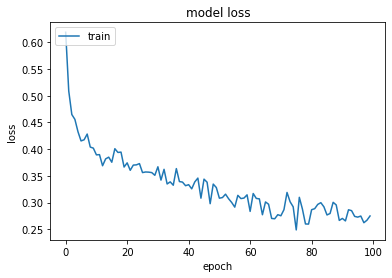

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Save result in CSV

In [ ]:
method = 'DGCNN'
#@title  { form-width: "30%" }
outpath = '/content/drive/MyDrive/CDS-GROUP-ROOT/TUDatasets/LION15_results' #@param {type:"string"}
from datetime import datetime
import pandas as pd
path = os.path.join(outpath, f'{method}_{dataset}_e{params["epochs"]}_l{params["layerdim"]}.csv')
if not os.path.exists(path):
  dfres = pd.DataFrame(columns=['mode', 'criteria', '% attack','avg edge del', 'acc','prec','f1','recall','MCC','cm', 'date', 'time'])
  dfres.to_csv(path, index=False)
dfres = pd.read_csv(path)
mode = 'test' if ontest else 'train'
dfres = dfres.append({'mode' : mode, 'criteria' : criteria, '% attack': str(percentage), 
                      'avg edge del' : "%.2f"%(float(summary.describe().iat[1,1]) - float(summary.describe().iat[1,3])),
                      'acc' : "%.2f\u00B1%.2f"%(tot_acc.mean(), tot_acc.std()), 
                      'prec' : "%.2f\u00B1%.2f"%(tot_prec.mean(), tot_prec.std()),
                      'f1' : "%.2f\u00B1%.2f"%(tot_F1.mean(), tot_F1.std()),
                      'recall' : "%.2f\u00B1%.2f"%(tot_recall.mean(), tot_recall.std()),
                      'MCC' : "%.2f\u00B1%.2f"%(tot_MCC.mean(), tot_MCC.std()),
                      'cm' : f'{confusion_matrix(tot_targets, tot_preds)}'.replace('\n',''),
                      'date': datetime.now().strftime("%m/%d/%Y, %H:%M:%S"),
                      'time' : expired}, ignore_index=True)
dfres.to_csv(path, index=False)
dfres

,mode,criteria,% attack,avg edge del,acc,prec,f1,recall,MCC,cm,date,time
0,test,betweeness,0,0,0.83±0.05,0.83±0.07,0.80±0.07,0.80±0.07,0.63±0.12,"[[ 45 18], [ 14 111]]","09/28/2021, 10:02:04",0:29:25
1,test,betweeness,5.0,0.49,0.85±0.04,0.84±0.06,0.82±0.05,0.83±0.07,0.66±0.11,"[[ 48 15], [ 14 111]]","09/28/2021, 10:33:58",0:29:24


# Timing estimates
A complete validation cycle takes 13 minutes on Mutag (with 100 epochs).